In [68]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, AveragePooling2D, ConvLSTM2D
from keras.layers import Dropout, Dense, TimeDistributed, RepeatVector
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank
import pickle
from keras.callbacks import ModelCheckpoint
from cfg import Config


In [2]:
def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [48]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('smallclean/'+file)
        label = rand_class
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(label))
    
    
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    X = (X - _min)/(_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    elif config.mode == 'crnn':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'convbneck':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = to_categorical(y, num_classes=3)
    
    config.data = (X, y)
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=2)

    return X, y

In [35]:
class_dist2

label
background    183.692715
glass         183.366310
screams       184.277901
Name: length, dtype: float64

In [42]:
def build_rand_feat2():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples2)):
        rand_class = np.random.choice(class_dist2.index, p = prob_dist2)
        file = np.random.choice(df2[df2.label==rand_class].index)
        rate, wav = wavfile.read('smallclean/'+file)
        label = rand_class
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes2.index(label))
    
    
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    X = (X - _min)/(_max - _min)
    
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    
    y = to_categorical(y, num_classes=2)
    
    config.data = (X, y)
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=2)

    return X, y

In [59]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', strides=1, padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim=3, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [19]:
def get_conv_bneck_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(AveragePooling2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim=3, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [69]:
def get_crnn_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(RepeatVector(input_shape[1]))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    model.build(input_shape)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [6]:
def get_recurrent_model():
    #shape of data for RNN is (n, time, feat)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    model.build(input_shape)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [44]:
def get_recurrent_model2():
    #shape of data for RNN is (n, time, feat)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    model.build(input_shape)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [32]:
df2 = pd.read_csv('data/Train_labels.csv')
df2.set_index('fname', inplace=True)

In [7]:
df = pd.read_csv('data/smalltrain.csv')
df.set_index('fname', inplace=True)

In [8]:
for f in df.index:
    rate, signal = wavfile.read('smallclean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

In [37]:
for f in df2.index:
    rate, signal = wavfile.read('smallclean/'+f)
    df2.at[f, 'length'] = signal.shape[0]/rate

In [38]:
classes2 = list(np.unique(df2.label))
class_dist2 = df2.groupby(['label'])['length'].mean()

In [9]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

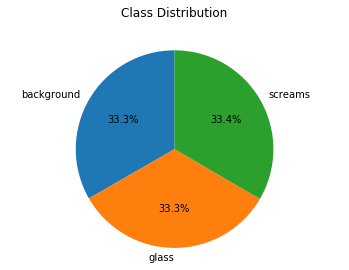

In [40]:
n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

n_samples2 = 2 * int(df2['length'].sum()/0.1)
prob_dist2 = class_dist2 / class_dist2.sum()
choices2 = np.random.choice(class_dist2.index, p=prob_dist2)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [11]:
'''class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat= 13, nfft=512, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)
        self.model_path = os.path.join('models', mode+ '.model')
        self.p_path = os.path.join('pickles', mode + '.p')
'''


"class Config:\n    def __init__(self, mode='conv', nfilt=26, nfeat= 13, nfft=512, rate=16000):\n        self.mode = mode\n        self.nfilt = nfilt\n        self.nfeat = nfeat\n        self.nfft = nfft\n        self.rate = rate\n        self.step = int(rate/10)\n        self.model_path = os.path.join('models', mode+ '.model')\n        self.p_path = os.path.join('pickles', mode + '.p')\n"

In [12]:
'''config = Config(mode='conv')
if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_crnn_model()'''

"config = Config(mode='conv')\nif config.mode == 'conv':\n    X, y = build_rand_feat()\n    y_flat = np.argmax(y, axis=1)\n    input_shape = (X.shape[1], X.shape[2], 1)\n    model = get_crnn_model()"

In [70]:
config = Config(mode='crnn')
if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
elif config.mode == 'time2':
    X, y = build_rand_feat2()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model2()
elif config.mode == 'convbneck':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_bneck_model()
elif config.mode == 'crnn':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_crnn_model()
 
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max', save_best_only=True, save_weights_only=False, period=1)




Loading existing data for crnn model
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 9, 13, 16)         160       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 9, 13, 32)         4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 6, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 6, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 768)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 13, 768)           0         
_________________________________________________________________
lstm_6 (LSTM)   

In [71]:
model.fit(X, y, epochs=10, batch_size=32, shuffle=True, class_weight=class_weight, validation_split=0.1, callbacks=[checkpoint])
model.save(config.model_path)

Train on 496202 samples, validate on 55134 samples
Epoch 1/10
496202/496202 [==============================] - 604s 1ms/step - loss: 0.4212 - acc: 0.7984 - val_loss: 0.3104 - val_acc: 0.8445

Epoch 00001: val_acc improved from -inf to 0.84447, saving model to models/crnn.model
Epoch 2/10
496202/496202 [==============================] - 605s 1ms/step - loss: 0.3148 - acc: 0.8436 - val_loss: 0.2805 - val_acc: 0.8590

Epoch 00002: val_acc improved from 0.84447 to 0.85900, saving model to models/crnn.model
Epoch 3/10
496202/496202 [==============================] - 602s 1ms/step - loss: 0.2921 - acc: 0.8535 - val_loss: 0.2648 - val_acc: 0.8699

Epoch 00003: val_acc improved from 0.85900 to 0.86986, saving model to models/crnn.model
Epoch 4/10
496202/496202 [==============================] - 602s 1ms/step - loss: 0.2780 - acc: 0.8603 - val_loss: 0.2469 - val_acc: 0.8723

Epoch 00004: val_acc improved from 0.86986 to 0.87229, saving model to models/crnn.model
Epoch 5/10
496202/496202 [======

In [48]:
classes

['background', 'glass', 'screams']